# __Optimizing Medical Insurance Premium Prediction Through Machine Learning__

## <u>__Project Overview__<u>

### __Develop a machine learning model to predict medical insurance premiums for customers based on their input attributes, providing an efficient and accurate solution for handling online inquiries and applications.__

### __Medical insurance companies receive numerous inquiries about premium costs due to online policy issues. Manually addressing these inquiries is time-consuming and inefficient. This project aims to build a predictive model that estimates premiums based on customer-specific features such as age, sex, BMI, children, smoking habits, and region.__

### __Import the required libraries.__

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

#### __Read the file to get an overview.__

In [2]:
file=pd.read_csv(r"MedicalInsurancePremium.csv")
file.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### __We can observe from the above output that there are no null values. So, Now lets check for duplicate values and remove them.__

In [4]:
file.duplicated().sum()

1

In [5]:
df=file.drop_duplicates()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### __Get a complete overview of the dataset.__

In [6]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.describe(include=['O'])

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


## <u>__Exploratory Data Analysis.__<u>

### __Lets use graphs for different types of feature to exploe the dataset to get better understanding.__

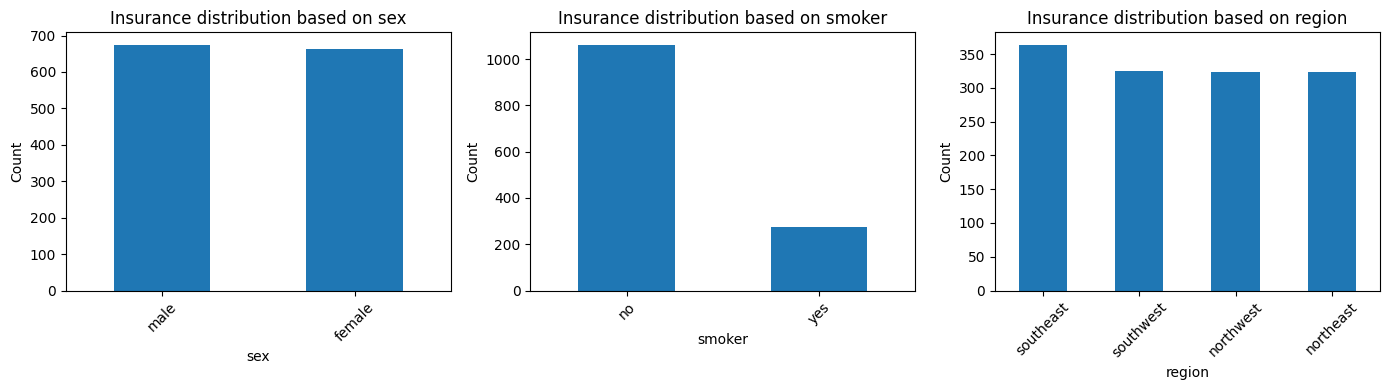

In [8]:
plt.figure(figsize=(14, 4))
for i, col in enumerate(df.select_dtypes(include='object').columns):
    num_cols = len(df.select_dtypes(include='object').columns)
    plt.subplot(1, num_cols, i+1)
    value_counts = df[col].value_counts()
    value_counts.plot(kind='bar')
    plt.title(f'Insurance distribution based on {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

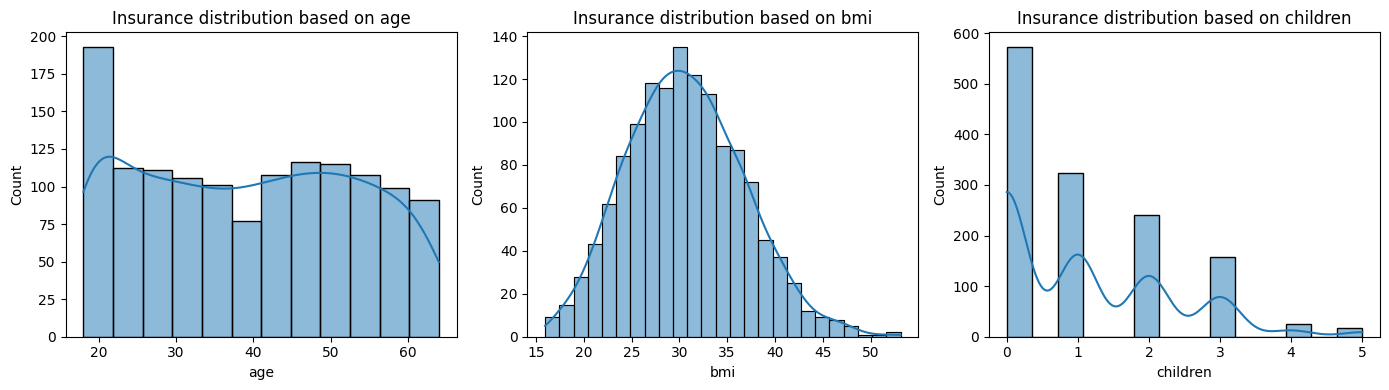

In [9]:
numerc_c=df[['age', 'bmi', 'children']]
plt.figure(figsize=(14, 4))
for j, column in enumerate(numerc_c):
    num_column = 3
    plt.subplot(1, num_column, j%num_column +1) 
    sns.histplot(df[column], kde=True, stat='count')
    plt.title(f'Insurance distribution based on {column}') 
    plt.xlabel(column) 
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

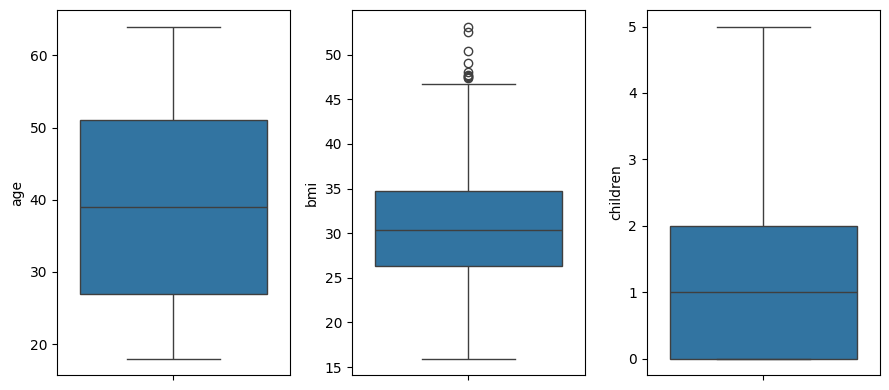

In [10]:
plt.figure(figsize=(9,4))
for k, columns in enumerate(numerc_c.columns):
    #num=2
    plt.subplot(1, 3, k+1)
    sns.boxplot(df[columns])
plt.tight_layout()
plt.show()

### __Lets check for outliers, we have to be carefull when removing outliers, outliers can effect the model performance.__

In [11]:
def detect_outliers_iqr(dataset):
    outliers=[]
    for column in dataset.columns:
        q1,q3=np.percentile(dataset[column], [25,75])
        iqr=q3-q1
        lower_fences=q1-(1.5*iqr)
        higher_fences=q3+(1.5*iqr)
        outlier_indices = dataset[(dataset[column] < lower_fences) | (dataset[column] > higher_fences)].index
        outliers.extend(outlier_indices)
    return set(outliers)

In [12]:
ds=detect_outliers_iqr(numerc_c)
ds

{116, 286, 401, 543, 847, 860, 1047, 1088, 1317}

In [13]:
df_cleaned = df.drop(index=ds)
df_cleaned

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### __Lets recheck for outliers.__

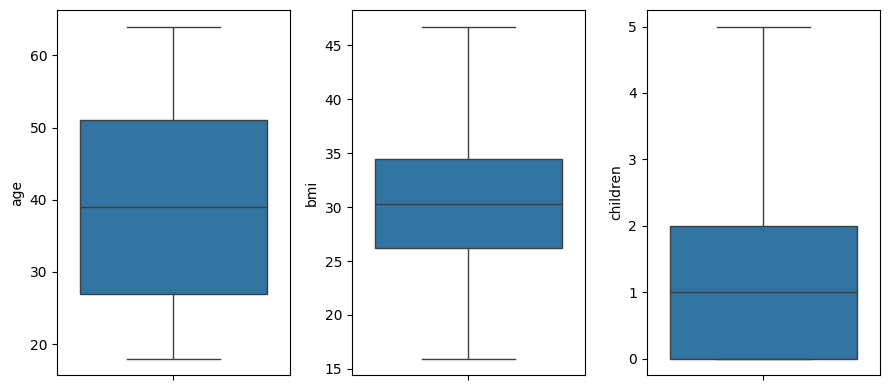

In [14]:
plt.figure(figsize=(9,4))
for k, columns in enumerate(numerc_c.columns):
    #num=2
    plt.subplot(1, 3, k+1)
    sns.boxplot(df_cleaned[columns])
plt.tight_layout()
plt.show()

### __Its important to transform the categorical features into numerical one. So, we will apply LabekEncoder technnique in object type features.__

In [15]:
le=LabelEncoder()
for n in df_cleaned.columns:
    if df_cleaned[n].dtypes=='object':
        df_cleaned[n]=le.fit_transform(df_cleaned[n].values.reshape(-1,1))
df_cleaned

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


### __Now, before we go for the model training , lets check the relationship of the reponse variable columns vs predictor variable columns.__

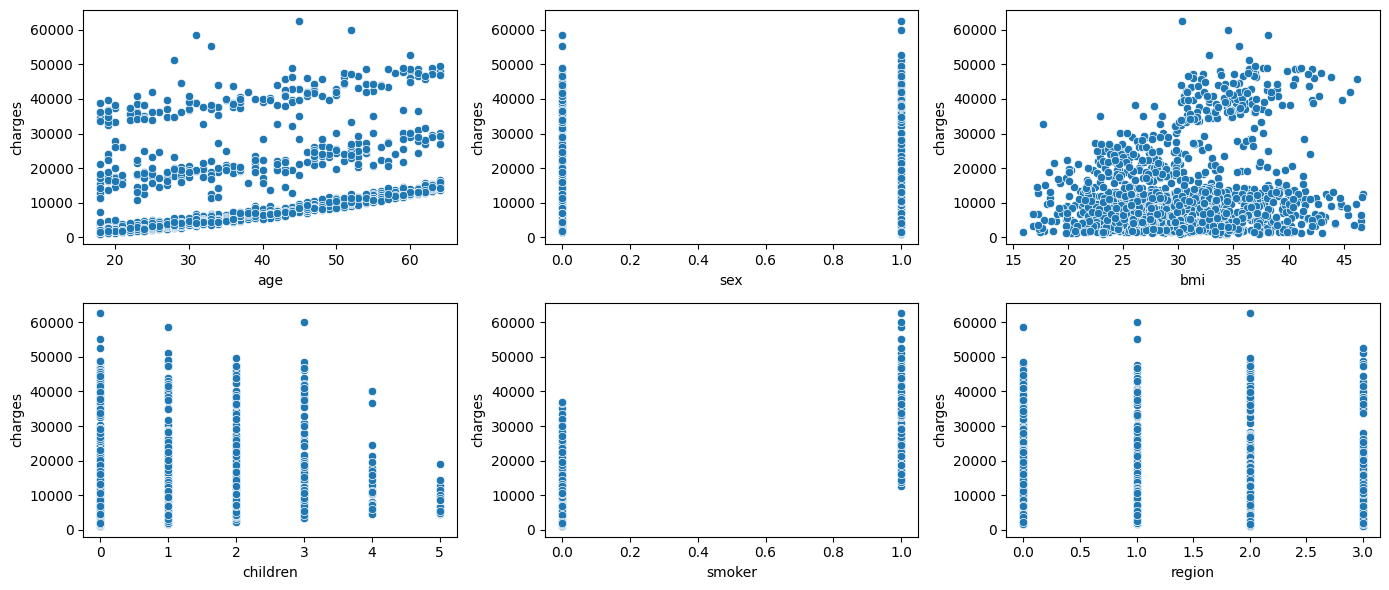

In [16]:
x=df_cleaned.drop('charges', axis=1)
y=df_cleaned['charges']
plt.figure(figsize=(14, 6))
for m, clmn in enumerate(x.columns):
    plt.subplot(2, 3, m + 1)  # Create subplots
    sns.scatterplot(x=clmn, y="charges", data=df_cleaned)
plt.tight_layout()
plt.show()

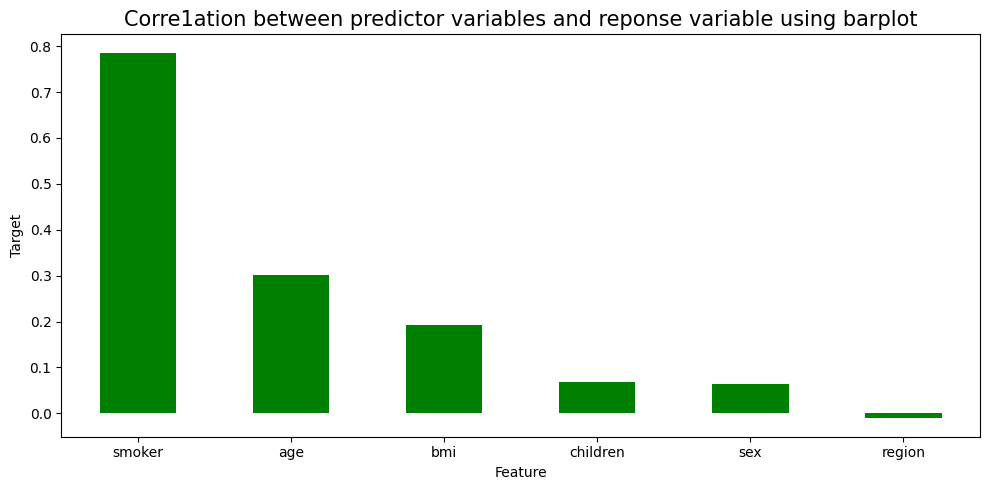

In [17]:
plt.figure(figsize=(10,5))
df_cleaned.corr()['charges'].sort_values(ascending=False).drop(['charges']).plot(kind='bar', color='g')
plt.xlabel('Feature', fontsize=10)
plt.ylabel ("Target", fontsize=10)
plt.title("Corre1ation between predictor variables and reponse variable using barplot", fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## <u>__Feature Scalling__<u>

### __We will be using Random Forest regression model and it is less sensetive to Feature Scalling but still to avoid any disturbance, lets imply feature scalling technique for better model performance, prevent biasness and for better data interpretation, we will apply StandardScaler feature scalling technique into whole dataset.__

In [18]:
scaler=StandardScaler()
x=pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x

,age,sex,bmi,children,smoker,region
0,-1.440429,-1.007559,-0.445495,-0.908563,1.974935,1.343447
1,-1.511669,0.992498,0.546068,-0.080442,-0.506346,0.439649
2,-0.799261,0.992498,0.415999,1.575799,-0.506346,0.439649
3,-0.443056,0.992498,-1.323037,-0.908563,-0.506346,-0.464149
4,-0.514297,0.992498,-0.279953,-0.908563,-0.506346,-0.464149
...,...,...,...,...,...,...
1323,0.768039,0.992498,0.073091,1.575799,-0.506346,-0.464149
1324,-1.511669,-1.007559,0.233565,-0.908563,-0.506346,-1.367947
1325,-1.511669,-1.007559,1.066343,-0.908563,-0.506346,0.439649
1326,-1.297947,-1.007559,-0.800228,-0.908563,-0.506346,1.343447


## <u>__Model Training, Pediction and Evaluation__<u>

### __Although random state doesnt effect the model much but when dealing with big dataset even slight difference can alter the model performance. So, its better to search for the best value for random state.__

In [19]:
def best_random_state(X, y, model, metric, random_states=range(0,101)):
    best_score = 0
    best_state = None
    for n in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
        model.fit(X_train, y_train)
        score = metric(y_test, model.predict(X_test))
        if score > best_score:
            best_score = score
            best_state = n
    return best_state, best_score
model = RandomForestRegressor()
best_state, best_score = best_random_state(x, y, model, r2_score)
print("Best random state:", best_state)
print("Best accuracy:", best_score)

Best random state: 19
Best accuracy: 0.8910081118601276


In [20]:
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.30, random_state=19)
rfm=RandomForestRegressor()
rfm.fit(x_train,y_train)
pred_rfmtrn=rfm.predict(x_train)
pred_rfmtst=rfm.predict(x_test)
print(rfm)
print("R2 Score:", r2_score(y_train,pred_rfmtrn))
print("R2 Score:", r2_score(y_test,pred_rfmtst))
print("Mean Absolute Error:", mean_absolute_error(y_test,pred_rfmtst))
print("Mean Squared Error:", mean_squared_error(y_test,pred_rfmtst))

RandomForestRegressor()
R2 Score: 0.9697998574965505
R2 Score: 0.8932590986501863
Mean Absolute Error: 2488.681108799574
Mean Squared Error: 16548281.511293022


### __In the above steps, we have trained a "Random Forest" model and predicted charges using test dataset, but there is little disturbance we can observe, there is some difference between the result of the model when used traing dataset and then when used test dataset, its clear indication of overfitting. So, lets search the best performance of Random Forest by hyperparameter tuning.__

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_params)
print(best_model)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=2)


### __In the above steps we got some parameters that we can use to modify our model for some better performance.__

In [26]:
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.30, random_state=19)
rfm_h=RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=100)
rfm_h.fit(x_train,y_train)
pred_rfmtrn_h=rfm_h.predict(x_train)
pred_rfmtst_h=rfm_h.predict(x_test)
print("R2 Score for Training dataset:", r2_score(y_train,pred_rfmtrn_h))
print("R2 Score for Test dataset:", r2_score(y_test,pred_rfmtst_h))
print("Mean Absolute Error:", mean_absolute_error(y_test,pred_rfmtst_h))
print("Mean Squared Error:", mean_squared_error(y_test,pred_rfmtst_h))

R2 Score for Training dataset: 0.9102086130958785
R2 Score for Test dataset: 0.9052900308987
Mean Absolute Error: 2593.128406291937
Mean Squared Error: 14683099.081933258


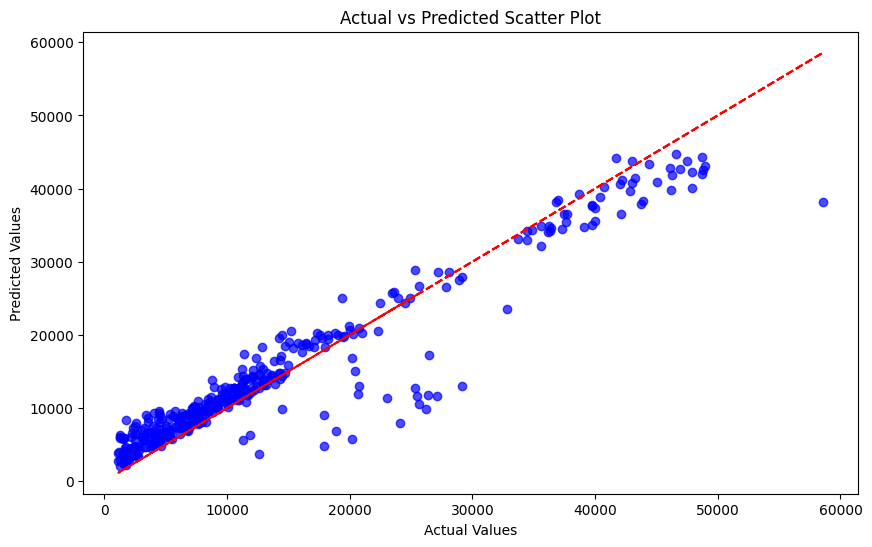

In [27]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_rfmtst_h, alpha=0.7, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='--')  # Diagonal line
plt.title('Actual vs Predicted Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()